##***DeepFake Detection Using Deep Learning***




## **Setup and Library Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
!pip3 install face_recognition 

     |████████████████████████████████| 100.1 MB 21 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=ab6d7e5f07141b02cb9c7d9616e63735e42c848dde8b9474f30d222a5527076c
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
import os
import glob
import json
import copy
import random
import time
import sys
import torch
import cv2
from torch import nn
import seaborn as sn
import pandas as pd
import numpy as np
import torchvision
import face_recognition
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt 
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## **Helper Functions**

In [ ]:
#Function to plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
#Function to calcuate accuracy
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [ ]:
# Function to compute and store the average and current value"""
class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
#Function to print confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [ ]:
#Function for plotting loss and accuracy
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
    loss_train = train_loss_avg
    loss_val = test_loss_avg
    #print(num_epochs)
    epochs = range(1,num_epochs+1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
    loss_train = train_accuracy
    loss_val = test_accuracy
    epochs = range(1,num_epochs+1)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

##**Data Preprocessing**

In [ ]:
#Function to check valid videos 
def validate_video(vid_path,train_transforms):
      transform = train_transforms
      count=20
      video_path = vid_path
      frames = []
      temp_video = video_path.split('/')[-1]
      for i,frame in enumerate(frame_extract(video_path)):
        frames.append(transform(frame))
        if(len(frames) == count):  #check if no. of  frames is equal to a minimum count
          break
      frames = torch.stack(frames)
      frames = frames[:count]
      return frames
      
#extract a from from video
def frame_extract(path):
  vidObj = cv2.VideoCapture(path) 
  success = 1
  while success:
      success, image = vidObj.read()
      if success:
          yield image

#apply transformations to frames
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)]) 
video_fil =  glob.glob('/content/drive/MyDrive/Celeb_real_face_only/*.mp4')
video_fil += glob.glob('/content/drive/MyDrive/Celeb_fake_face_only/*.mp4')

print("Total no of videos :" , len(video_fil))
count = 0;
for i in video_fil:
  try:
    count+=1
    validate_video(i,train_transforms)
  except:
    print("Number of video processed: " , count ," Remaining : " , (len(video_fil) - count))
    print("Corrupted video is : " , i)
    continue
print("Finished Validating Videos") 

Total no of videos : 1168
Finished Validating Videos


In [ ]:
#read files
video_files =  glob.glob('/content/drive/MyDrive/Celeb_real_face_only/*.mp4')
video_files += glob.glob('/content/drive/MyDrive/Celeb_fake_face_only/*.mp4')


random.shuffle(video_files)

frame_count = []

#check the average no. of frames in the input samples.
for video_file in video_files:
    cap = cv2.VideoCapture(video_file)
    if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
        video_files.remove(video_file)
        continue
    frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print('Average frame per video:',np.mean(frame_count))

Average frame per video: 147.95719178082192


## **Data Splitting and Loading**

In [ ]:
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    
    def __len__(self):
        return len(self.video_names)
    
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        
        #read video
        temp_video = video_path.split('/')[-1]
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        
        #assign labels
        if(label == 'FAKE'):
            label = 0
        if(label == 'REAL'):
            label = 1
        
        #extract frames and form a stack of frames   
        for i,frame in enumerate(self.frame_extract(video_path)):
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
                break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames,label
    
    def frame_extract(self,path):
        vidObj = cv2.VideoCapture(path) 
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                  yield image

In [ ]:
#Function to count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
    header_list = ["file","label"]
    lab = pd.read_csv('/content/drive/MyDrive/Gobal_metadata.csv',names=header_list)
    
    fake = 0
    real = 0
    for i in data_list:
        temp_video = i.split('/')[-1]
        label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
            fake+=1
        if(label == 'REAL'):
            real+=1
    return real,fake

train :  934
test :  234
TRAIN:  Real: 479  Fake: 455


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TEST:  Real: 109  Fake: 125


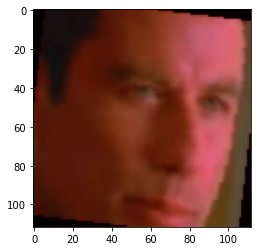

In [ ]:
header_list = ["file","label"]
#read the metadata
labels = pd.read_csv('/content/drive/MyDrive/Gobal_metadata.csv',names=header_list)

#split the data into train and test
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


#Augment the data by applying transformations to train and test set
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomRotation(10),
                                        transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.5, 0.5)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

#preprocess the data
train_data = video_dataset(train_videos,labels,sequence_length = 15,transform = train_transforms)
val_data = video_dataset(valid_videos,labels,sequence_length = 15,transform = test_transforms)

#load the data into dataloaders
train_loader = DataLoader(train_data,batch_size = 16,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 16,shuffle = True,num_workers = 4)

#plot the data
image,label = train_data[0]
im_plot(image[0,:,:,:])

## **Model 1 : Convolution Neural Network**

In [ ]:
#Baseline CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3,32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(32,32, kernel_size=(3, 3))
        self.max1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(32,64, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(64,64, kernel_size=(3, 3))
        self.max2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv5 = nn.Conv2d(64,128, kernel_size=(3, 3))
        self.conv6 = nn.Conv2d(128,128, kernel_size=(3, 3))
        self.max3 = nn.AvgPool2d(kernel_size=(2, 2))
        self.drop = nn.Dropout(p=0.3)

        # 4x dense layers to learn from features extracted from convolutions
        self.l1 = nn.Linear(12800,584)
        self.l2 = nn.Linear(584,128)
        self.l3 = nn.Linear(128,32)
        self.l4 = nn.Linear(32,2) 

    def forward(self, x):
                
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        x = F.relu(self.conv1(x)) 
        x = F.relu(self.conv2(x))
        x = self.max1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.max2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.max3(x)        
        x = x.view(x.shape[0],-1)
        x = F.leaky_relu(self.l1(x))   
        x = F.leaky_relu(self.l2(x))
        x = self.drop(x)
        x = F.relu(self.l3(x))
        x = self.l4(x)
        output = F.softmax(x, dim=1)
        return output


In [ ]:
#instantiate the model
model1 = CNNModel().cuda()

In [ ]:
#train function for CNN Model
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
       
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        
        bs,seq_length, c, h, w = inputs.shape
        outputs = model(inputs)   #call the model with inputs
        results = torch.zeros((bs,2)).cuda()
        c = 0 

        #calculate the mean output for each frame in the input sequence.
        for j in range(0,bs,seq_length):
            results[c] = torch.mean(outputs[j:j+seq_length],dim=0)
            c = c+1    

        #calculate loss and accuracy
        loss  = criterion(results,targets.type(torch.cuda.LongTensor))    
        acc = calculate_accuracy(results, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write( 
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/CNN_Model.pt')
    return losses.avg,accuracies.avg

#test function
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.LongTensor)
                inputs = inputs.cuda()
           

            batch_size,seq_length, c, h, w = inputs.shape
            outputs = model(inputs)
            results = torch.zeros((batch_size,2)).cuda()
            c = 0
            for j in range(0,batch_size,seq_length):
                results[c] = torch.mean(outputs[j:j+seq_length],dim=0)
                c = c+1
            loss = torch.mean(criterion(results, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(results,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(results,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [ ]:
#learning rate
lr = 0.001

#number of epochs 
num_epochs = 20

optimizer = torch.optim.Adam(model1.parameters(), lr= lr)

criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model1,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model1,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)

[Epoch 1/20] [Batch 58 / 59] [Loss: 0.693504, Acc: 49.36%]Testing
[Batch 14 / 15]  [Loss: 0.692863, Acc: 50.85%]
Accuracy 50.85470085470085
[Epoch 2/20] [Batch 58 / 59] [Loss: 0.693180, Acc: 49.79%]Testing
[Batch 14 / 15]  [Loss: 0.693179, Acc: 44.87%]
Accuracy 44.87179487179487
[Epoch 3/20] [Batch 58 / 59] [Loss: 0.693148, Acc: 49.89%]Testing
[Batch 14 / 15]  [Loss: 0.693106, Acc: 47.01%]
Accuracy 47.00854700854701
[Epoch 4/20] [Batch 58 / 59] [Loss: 0.693238, Acc: 50.32%]Testing
[Batch 14 / 15]  [Loss: 0.693303, Acc: 47.01%]
Accuracy 47.00854700854701
[Epoch 5/20] [Batch 58 / 59] [Loss: 0.693207, Acc: 50.21%]Testing
[Batch 14 / 15]  [Loss: 0.693180, Acc: 47.01%]
Accuracy 47.00854700854701
[Epoch 6/20] [Batch 58 / 59] [Loss: 0.693093, Acc: 50.32%]Testing
[Batch 14 / 15]  [Loss: 0.693474, Acc: 47.01%]
Accuracy 47.00854700854701
[Epoch 7/20] [Batch 58 / 59] [Loss: 0.693385, Acc: 50.32%]Testing
[Batch 14 / 15]  [Loss: 0.693194, Acc: 47.01%]
Accuracy 47.00854700854701
[Epoch 8/20] [Batch 

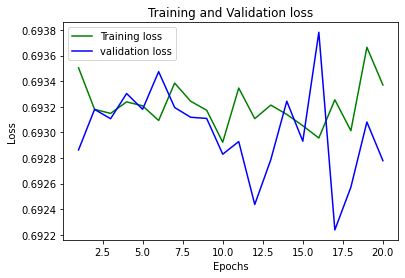

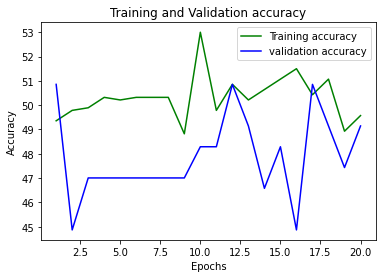

In [ ]:
#plot of loss and accuracy for CNN
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))

[[ 98  12]
 [107  17]]
True positive =  98
False positive =  12
False negative =  107
True negative =  17




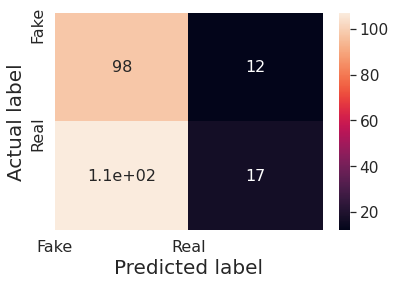

Calculated Accuracy 49.14529914529914


In [ ]:
#confusion matrix for CNN 
print(confusion_matrix(true,pred)) 
print_confusion_matrix(true,pred) 

## **Model 2: ResNext + LSTM**

In [ ]:
# Model with Pretrained ResNext with LSTM layers
class ResNext_LSTM_Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(ResNext_LSTM_Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN pretrained model
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional) #LSTM Layer
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,512)
        self.linear2 = nn.Linear(512,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(self.relu(fmap))
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        x = F.relu(self.linear1(torch.mean(x_lstm,dim = 1)))
        x = self.dp(x)
        x = self.linear2(x)
        return fmap, x #return the feature map from ResNext and model output

In [ ]:
#instantiate the model
model2 = ResNext_LSTM_Model(2).cuda()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [ ]:
#Train funtion for ResNext_LSTM_Model
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/ResNext_LSTM_Model.pt') #save the model
    return losses.avg,accuracies.avg

#Test Function for ResNext_LSTM_Model
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [ ]:
#learning rate
lr = 1e-5 #0.001
#number of epochs 
num_epochs = 10

optimizer = torch.optim.Adam(model2.parameters(), lr= lr,weight_decay = 0.001)
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = [] 
test_accuracy = []

#call the train and test to fit the model
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model2,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model2,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc) 

[Epoch 1/10] [Batch 58 / 59] [Loss: 0.691831, Acc: 53.21%]Testing
[Batch 14 / 15]  [Loss: 0.683294, Acc: 54.27%]
Accuracy 54.27350427350427
[Epoch 2/10] [Batch 58 / 59] [Loss: 0.666473, Acc: 64.24%]Testing
[Batch 14 / 15]  [Loss: 0.643949, Acc: 68.38%]
Accuracy 68.37606837606837
[Epoch 3/10] [Batch 58 / 59] [Loss: 0.517080, Acc: 80.73%]Testing
[Batch 14 / 15]  [Loss: 0.529146, Acc: 73.50%]
Accuracy 73.5042735042735
[Epoch 4/10] [Batch 58 / 59] [Loss: 0.278978, Acc: 89.61%]Testing
[Batch 14 / 15]  [Loss: 0.366441, Acc: 83.33%]
Accuracy 83.33333333333333
[Epoch 5/10] [Batch 58 / 59] [Loss: 0.166457, Acc: 94.43%]Testing
[Batch 14 / 15]  [Loss: 0.316760, Acc: 86.75%]
Accuracy 86.75213675213675
[Epoch 6/10] [Batch 58 / 59] [Loss: 0.109028, Acc: 96.36%]Testing
[Batch 14 / 15]  [Loss: 0.326802, Acc: 86.32%]
Accuracy 86.32478632478633
[Epoch 7/10] [Batch 58 / 59] [Loss: 0.076024, Acc: 97.11%]Testing
[Batch 14 / 15]  [Loss: 0.397391, Acc: 85.04%]
Accuracy 85.04273504273505
[Epoch 8/10] [Batch 5

10


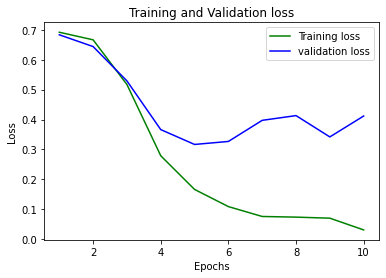

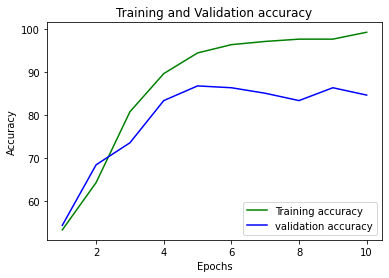

In [ ]:
#plot of loss and accuracy for ResNext_LSTM_Model
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))

[[ 87  20]
 [ 16 111]]
True positive =  87
False positive =  20
False negative =  16
True negative =  111




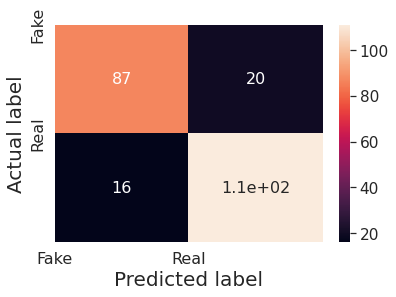

Calculated Accuracy 84.61538461538461


In [ ]:
#Confusion Matrix ResNext_LSTM_Model
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

## **Model 3: EfficientNet + GRU**

In [ ]:
#Model with Pretrained Efficient Net with GRU 
class Efficient_GRU_Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 1280, gru_layers=2 , hidden_dim = 1280, bidirectional = False):
        super(Efficient_GRU_Model, self).__init__()
        model = models.efficientnet_b0(pretrained = True) #Pretrained Efficient Net b0 Model
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.gru = nn.GRU(latent_dim, hidden_dim, gru_layers, bidirectional) #GRU Layer
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.3)
        self.linear1 = nn.Linear(1280,256)
        self.linear2 = nn.Linear(256,128)
        self.linear3 = nn.Linear(128,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape 
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,1280)
        x_gru,_ = self.gru(x,None)
        x = self.relu((self.linear1(torch.mean(x_gru,dim = 1))))
        x = self.relu(self.dp(self.linear2(x)))
        x = self.linear3(x)
        return fmap,x

In [ ]:
#instantiate the  Efficient_GRU_Model
model3 = Efficient_GRU_Model(2,bidirectional=True).cuda()

In [ ]:
#train function for Efficient_GRU_Model
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'EfficientNet_GRU_Model.pt')
    return losses.avg,accuracies.avg

#test function for Efficient_GRU_Model
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [ ]:
#learning rate
lr = 1e-5
#number of epochs 
num_epochs = 20

optimizer = torch.optim.Adam(model3.parameters(), lr= lr,weight_decay = 1e-5)

criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model3,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model3,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 1/20] [Batch 58 / 59] [Loss: 0.693480, Acc: 50.00%]Testing
[Batch 14 / 15]  [Loss: 0.692777, Acc: 50.85%]
Accuracy 50.85470085470085
[Epoch 2/20] [Batch 58 / 59] [Loss: 0.692329, Acc: 53.21%]Testing
[Batch 14 / 15]  [Loss: 0.692407, Acc: 54.27%]
Accuracy 54.27350427350427
[Epoch 3/20] [Batch 58 / 59] [Loss: 0.690831, Acc: 56.32%]Testing
[Batch 14 / 15]  [Loss: 0.690874, Acc: 57.26%]
Accuracy 57.26495726495727
[Epoch 4/20] [Batch 58 / 59] [Loss: 0.687944, Acc: 59.31%]Testing
[Batch 14 / 15]  [Loss: 0.687014, Acc: 58.55%]
Accuracy 58.547008547008545
[Epoch 5/20] [Batch 58 / 59] [Loss: 0.679578, Acc: 65.52%]Testing
[Batch 14 / 15]  [Loss: 0.672974, Acc: 66.24%]
Accuracy 66.23931623931624
[Epoch 6/20] [Batch 58 / 59] [Loss: 0.654534, Acc: 67.88%]Testing
[Batch 14 / 15]  [Loss: 0.649384, Acc: 67.95%]
Accuracy 67.94871794871794
[Epoch 7/20] [Batch 58 / 59] [Loss: 0.547790, Acc: 77.84%]Testing
[Batch 14 / 15]  [Loss: 0.517558, Acc: 75.21%]
Accuracy 75.21367521367522
[Epoch 8/20] [Batch

20


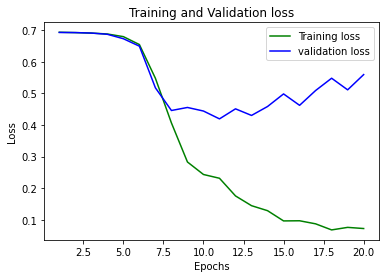

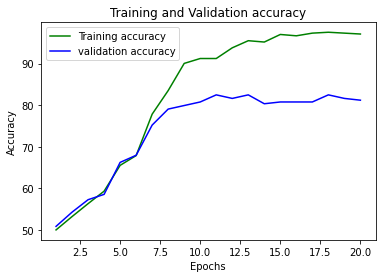

In [ ]:
#plot of loss and accuracy for Efficient_GRU_Model
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))

[[104  21]
 [  4 105]]
True positive =  104
False positive =  21
False negative =  4
True negative =  105




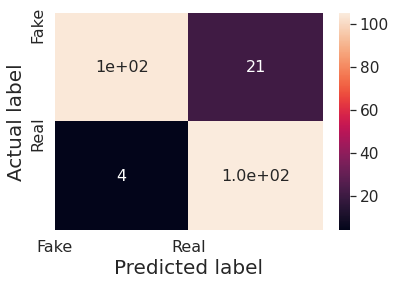

Calculated Accuracy 89.31623931623932


In [ ]:
#Confusion Matrix for Efficient_GRU_Model
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)